# How does the gain parameter affect Gabor bandwidth?

In [233]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments.batched_online import simulate, make_key

from utils import ipr, entropy, entropy_sort, mean_sort, var_sort, plot_receptive_fields, plot_rf_evolution

def simulate_or_load(**kwargs):
    path_key = make_key(**kwargs)
    if path_key + '.npz' in os.listdir('../localization/results/weights'):
        print('Already simulated')
        data = np.load('../localization/results/weights/' + path_key + '.npz', allow_pickle=True)
        weights_, metrics_ = data['weights'], data['metrics']
    else:
        print('Simulating')
        weights_, metrics_ = simulate(**kwargs)
    return weights_, metrics_

def build_gaussian_covariance(L, xi):
    C = np.abs(jnp.tile(jnp.arange(L)[:, jnp.newaxis], (1, L)) - jnp.tile(jnp.arange(L), (L, 1)))
    C = jnp.minimum(C, L - C)
    C = np.exp(-C ** 2 / (xi ** 2))
    return C

config_ = dict(
    # data config
    num_dimensions=40, xi1=2, xi2=1,
    # num_dimensions=100, xi1=6, xi2=3,
    dataset_cls=datasets.NonlinearGPDataset,
    batch_size=1000,
    support=(-1, 1), # defunct
    class_proportion=0.5,
    # model config
    model_cls=models.SimpleNet,
    num_hiddens=40,
    # num_hiddens=100,
    activation='relu',
    use_bias=False,
    sampler_cls=samplers.EpochSampler,
    init_fn=models.xavier_normal_init,
    init_scale=1.,
    # learning config
    num_epochs=5000,
    # num_epochs=20000,
    evaluation_interval=100,
    optimizer_fn=optax.sgd,
    learning_rate=5.,
    # experiment config
    seed=0,
    save_=True,
    wandb_=False,
)

from scipy.optimize import curve_fit
gabor_real = lambda x, c, a, x0, k0: c * np.cos(k0 * (x - x0)) * np.exp(-(x - x0) ** 2 / a ** 2)

def fit(weights):
    K, n = weights.shape
    p, var = np.zeros((K, 4)), np.zeros((K, 4))
    
    for k in range(K):    
        x0_init = np.argmax( np.abs(weights[k]) )
        x = np.arange(n) # np.linspace(0, n, 25 * n)
        y = weights[k] # np.tile(weights[k], 25).T.flatten()
        try:
            p_, cov = curve_fit(gabor_real, x, y, p0=[0.5, 10, x0_init, 0.01], bounds=([-1, 0, -np.inf, -2], [1, np.inf, np.inf, 2]))
            p[k] = p_
            var[k] = np.diag(cov)
        except Exception:
            p[k] = var[k] = np.nan
    
    return p, var

In [214]:
GAIN_SWEEP = np.linspace(0.01, 3, 21)
# GAIN_SWEEP = np.linspace(0.01, 10, 100)

Already simulated


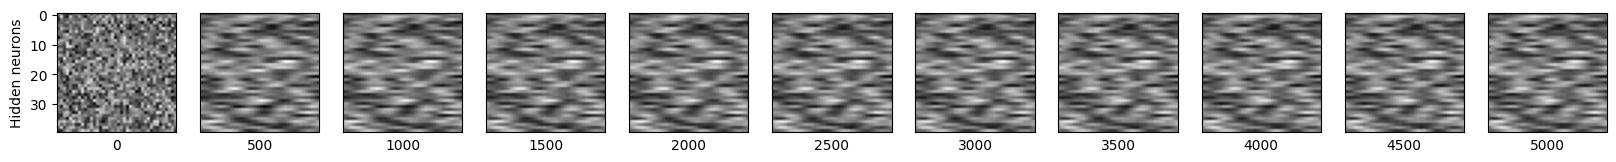

In [206]:
# high gain
config = config_.copy()
config.update(dict(
    gain = GAIN_SWEEP[0] # 10
))

weights, metrics = simulate_or_load(**config)
fig, axs = plot_receptive_fields(weights[::5], num_cols=11, evaluation_interval=5*100, figsize=(20, 10), reordering_fn=entropy_sort, ind=-1)

In [234]:
# sweep across gains
p, num = np.zeros((len(GAIN_SWEEP), 4)), np.zeros((len(GAIN_SWEEP), 4))
for i in range(len(GAIN_SWEEP)):
    config = config_.copy()
    config.update(dict(
        gain = GAIN_SWEEP[i] # 10
    ))

    weights, _ = simulate_or_load(**config)
    param, var = fit(weights[-1])
    p[i] = np.array([ np.mean(np.abs(p_[var_ < 0.2])) for (p_, var_) in zip(param.T, var.T) ])
    num[i] = np.array([ np.sum(var_ < 0.2) for var_ in var.T ])

Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated
Already simulated


Text(0.5, 1.0, 'k0')

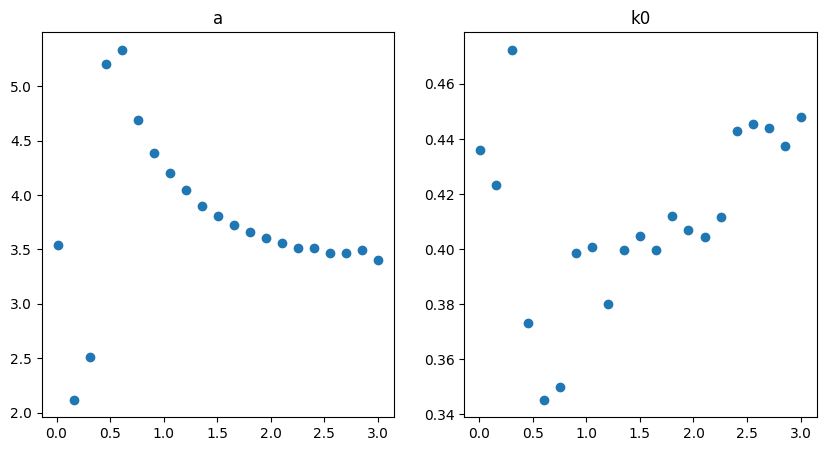

In [235]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
_ = ax1.plot(GAIN_SWEEP, p[:,1], 'o')
ax1.set_title('a')
_ = ax2.plot(GAIN_SWEEP, p[:,3], 'o')
ax2.set_title('k0')

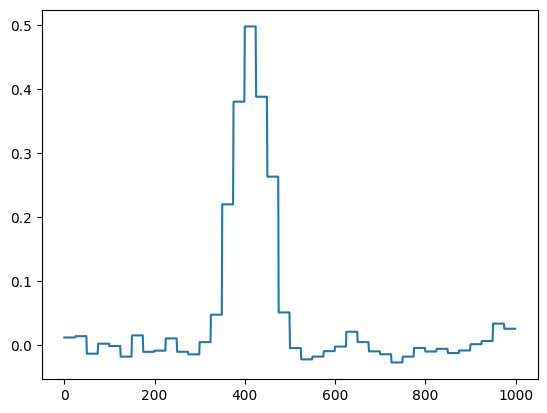

In [148]:
plt.plot( np.tile(weights[-1,1], (25,1)).T.flatten() )

In [149]:
x0_init = np.argmax( np.abs(weights[-1,1]) )
p_, cov = curve_fit(gabor_real, np.linspace(0,40,1000), np.tile(weights[-1,1], (25,1)).T.flatten(), p0=[0.5, 1., x0_init, 1])
print(p_)
print(cov)

[ 0.47580279  3.21693687 16.56122983 -0.40491555]
[[ 1.01154558e-05 -7.08904337e-05  3.07314068e-12 -1.84258551e-06]
 [-7.08904337e-05  2.92485498e-03 -1.14601394e-11 -1.18429709e-04]
 [ 3.07314068e-12 -1.14601394e-11  1.46005155e-04 -2.75402523e-12]
 [-1.84258551e-06 -1.18429709e-04 -2.75402523e-12  2.05661567e-05]]


In [100]:
x0_init = np.argmax( np.abs(weights[-1,1]) )
p_, cov = curve_fit(gabor_real, np.arange(40), weights[-1,1], p0=[0.5, 1., x0_init, 1])
print(p_)
print(cov)

[ 0.48329021 -3.18066217 15.99279888 -5.87204073]
[[ 1.19520882e-04  8.15452419e-04 -3.76033453e-06  2.13915416e-05]
 [ 8.15452419e-04  3.20916160e-02 -9.73785452e-05 -1.30469722e-03]
 [-3.76033453e-06 -9.73785452e-05  2.84711047e-05  7.38308705e-06]
 [ 2.13915416e-05 -1.30469722e-03  7.38308705e-06  2.36383206e-04]]


/Users/leonlufkin/opt/anaconda3/envs/ML/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


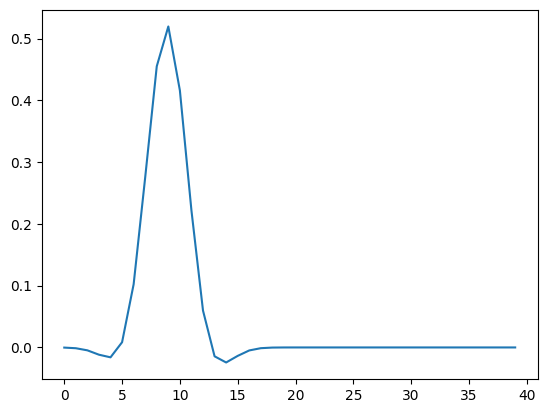

In [61]:
p = fit(weights[-1])
plt.plot( gabor_real(np.arange(40), *p[0][0]) )

/Users/leonlufkin/opt/anaconda3/envs/ML/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


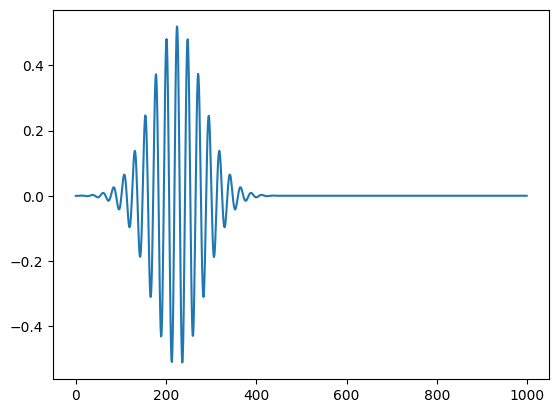

In [65]:
p = fit(weights[-1])
plt.plot( gabor_real(np.linspace(0,40,1000), *p[0][0]) )

Already simulated


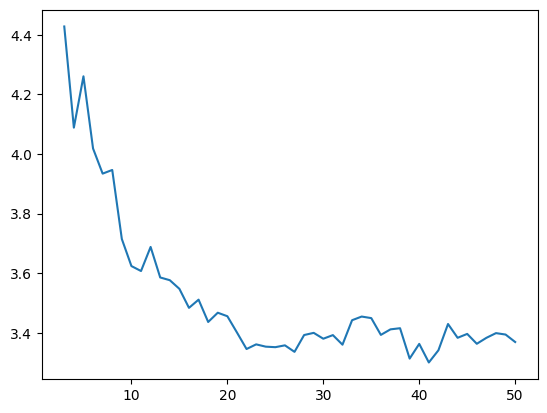

In [112]:
# sweep across time, for a fixed gain
config = config_.copy()
config.update(dict(
    gain = GAIN_SWEEP[-1]
))
weights, _ = simulate_or_load(**config)

metrics = np.zeros((len(weights), 2))
for t in range(len(weights)):
    p, var_p = fit_curve(weights[t])
    x = np.abs(p[var_p < 0.1])
    metrics[t,0] = np.mean(x)
    metrics[t,1] = len(x)
    
_ = plt.plot( metrics[:,0] )

Already simulated


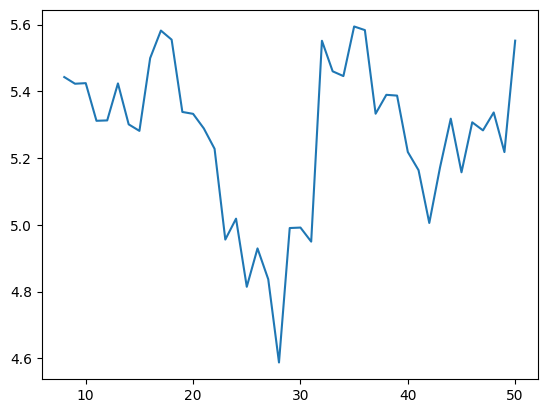

In [115]:
# sweep across time, for a fixed gain
config = config_.copy()
config.update(dict(
    gain = GAIN_SWEEP[4]
))
weights, _ = simulate_or_load(**config)

metrics = np.zeros((len(weights), 2))
for t in range(len(weights)):
    p, var_p = fit_curve(weights[t])
    x = np.abs(p[var_p < 0.1])
    metrics[t,0] = np.mean(x)
    metrics[t,1] = len(x)
    
_ = plt.plot( metrics[:,0] )